In [1]:
%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd
from math import sqrt
import scipy as sp

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Our very own survLime!
import survLime
from survlimepy.load_datasets import Loader 
#from survLime import survlime_explainer


dataset = 'lung'
loader = Loader(dataset_name=dataset)
x,events, times = loader.load_data()


train, val, test = loader.preprocess_datasets(x, events, times, random_seed=0, standarize=True)
events_train = [x[0] for x in train[1]]
times_train  = [x[1] for x in train[1]]

events_val = [x[0] for x in val[1]]
times_val  = [x[1] for x in val[1]]

events_test = [x[0] for x in test[1]]
times_test  = [x[1] for x in test[1]]


model = CoxPHSurvivalAnalysis(alpha=0.0001)
#model = RandomSurvivalForest()
model.fit(train[0], train[1])

def compare_survival_times(bb_model : CoxPHSurvivalAnalysis,
                           coefs : np.ndarray,
                           X_train : pd.DataFrame, y_train : np.ndarray, X_test : pd.DataFrame, true_coef : list = None):

    times_train = [x[1] for x in y_train]
    times_to_fill = list(set(times_train)); times_to_fill.sort()
    
    model_interpretable = CoxPHSurvivalAnalysis(alpha=0.0001)
    model_interpretable.fit(X_train, y_train)
    model_interpretable.coef_ = coefs
    # Obtain the predictions from both models
    preds_bb      = bb_model.predict_survival_function(X_test)
    preds_survlime = model_interpretable.predict_survival_function(X_test)

   
    # We need to do this to have the same size as the cox output
    if isinstance(bb_model, RandomSurvivalForest):
        preds_bb_y  = np.mean([fill_matrix_with_total_times(times_to_fill, x.y, list(x.x)) for x in preds_bb], axis=0)
    else:
        preds_bb_y  = np.mean([x.y for x in preds_bb], axis=0)

    preds_surv_y = np.mean([x.y for x in preds_survlime], axis=0)

    rmse = sqrt(mean_squared_error(preds_bb_y, preds_surv_y))
    if isinstance(bb_model, CoxPHSurvivalAnalysis):
        plot_num=2
        
        if true_coef:
            data  =  [bb_model.coef_, coefs, true_coef]
            index =  ['CoxPH', 'SurvLIME', 'True coef']
        else:
            data  = [bb_model.coef_, coefs]
            index = ['CoxPH','SurvLIME']
        df = pd.DataFrame(columns=bb_model.feature_names_in_, 
                  data=data, index=index)
        df = df.reindex(df.iloc[0].sort_values(ascending=False).index, axis=1)

        # Create axes and access them through the returned array
        fig, axs = plt.subplots(1, plot_num, figsize=(15,5))
        df.transpose().plot.bar(ax=axs[0])
        axs[0].set_title('Coefficient values for bb model and survlime')
        axs[1].step(preds_bb[0].x, preds_bb_y, where="post", label='BB model')
        axs[1].step(preds_survlime[0].x, preds_surv_y, where="post", label='SurvLIME')
        axs[1].legend()
        axs[1].set_title(f'Mean survival time comparison RMSE: {rmse:.3}')
    
    # If we are using other model, we don't have coefficients to compare with
    else:
        plt.figure()
        plt.step(preds_survlime[0].x, preds_bb_y, where="post", label='BB model')
        plt.step(preds_survlime[0].x, preds_surv_y, where="post", label='SurvLIME')
        plt.legend()
        plt.title(f'Mean survival time comparison RMSE: {rmse:.3}')

<frozen importlib._bootstrap>:219: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 1160 from PyObject


In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

compt_weights = pd.read_csv(f'/home/carlos.hernandez/PhD/survlime-paper/survLime/computed_weights_csv/exp3/rsf_exp_{dataset}_surv_weights_na_rand_seed_0.csv')
coef = model.coef_

dist = euclidean_distances(compt_weights, coef.reshape(1,-1))
closest = list(dist).index(min(dist))
furthest = list(dist).index(max(dist))


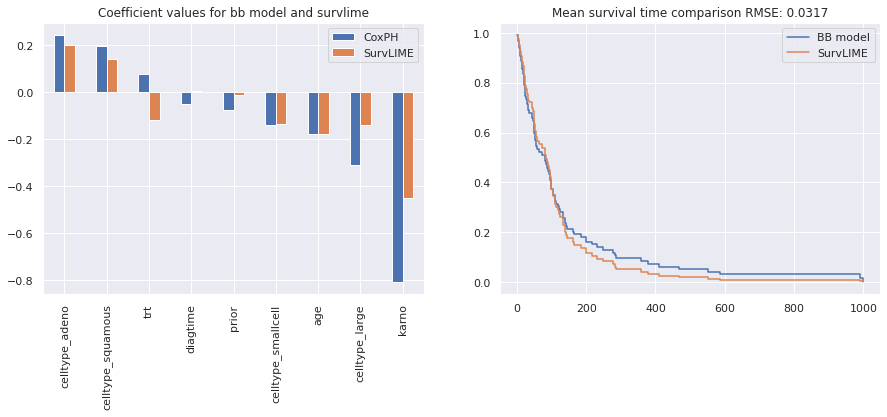

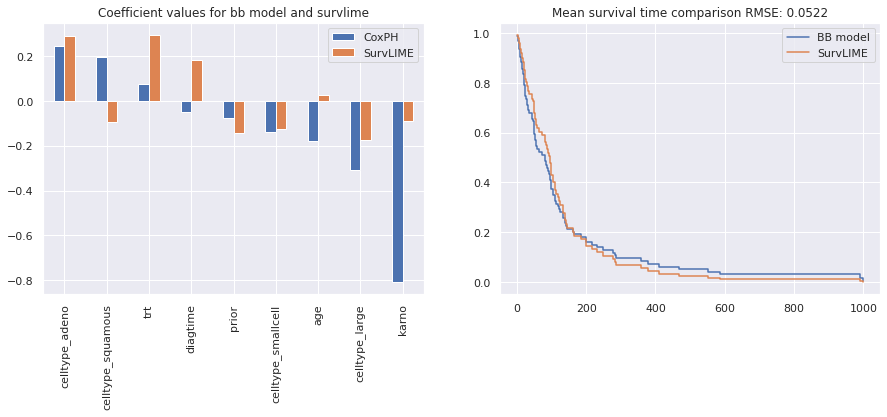

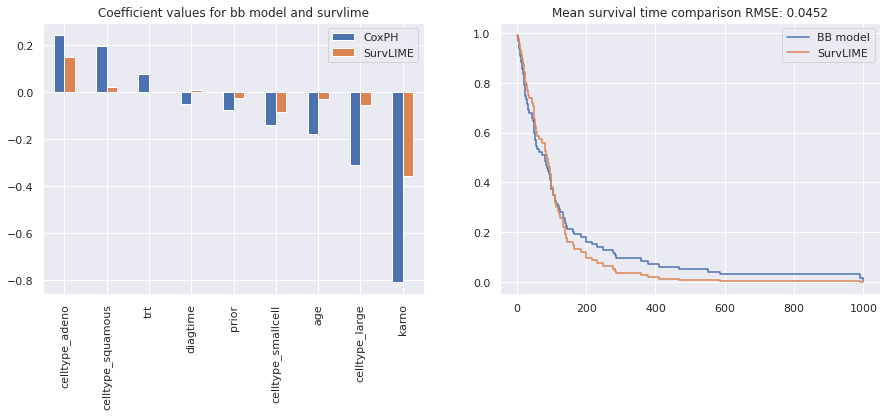

In [10]:
compare_survival_times(model, compt_weights.iloc[closest], train[0], train[1], test[0])
compare_survival_times(model, compt_weights.iloc[furthest], train[0], train[1], test[0])
compare_survival_times(model, compt_weights.mean(), train[0], train[1], test[0])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 509.36it/s]


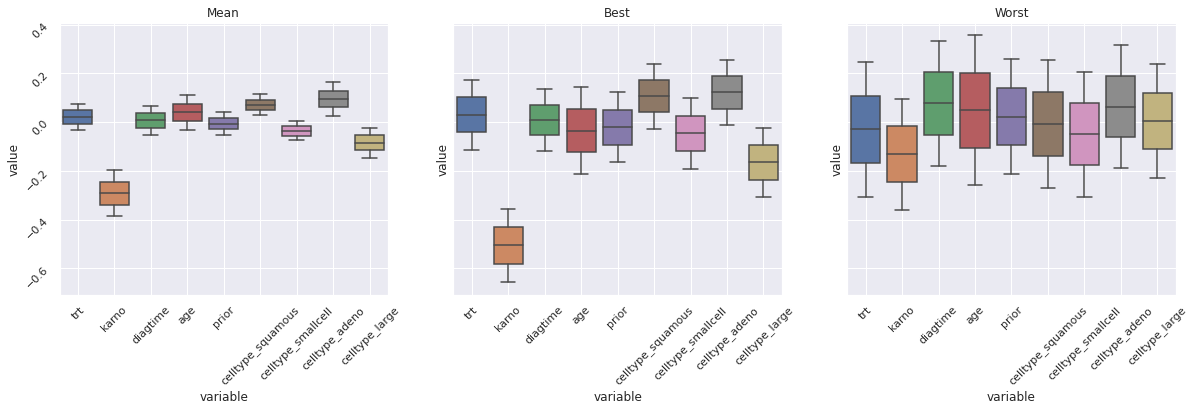

In [61]:
from tqdm import tqdm

mean_dfs, max_dfs, min_dfs = [], [], []
w_path = '/home/carlos.hernandez/PhD/survlime-paper/survLime/computed_weights_csv/exp3/'
coefficients = model.coef_

for i in tqdm(range(100)):
    compt_weights = pd.read_csv(w_path+f'rsf_exp_{dataset}_surv_weights_na_rand_seed_{i}.csv')
    compt_weights = compt_weights.dropna(axis=0)
    
    dist = euclidean_distances(compt_weights, np.array(coefficients).reshape(1,-1))
    closest = list(dist).index(min(dist))
    furthest = list(dist).index(max(dist))
    
    mean_dfs.append(compt_weights.mean())
    max_dfs.append(compt_weights.iloc[furthest])
    min_dfs.append(compt_weights.iloc[closest])
    
    # This will check whether the order of the values are the same. This ensures that the values don't have high variance
    if i!=0:
        if (compt_weights.iloc[furthest].sort_values(ascending=False).index == max_dfs[-1].sort_values(ascending=False).index).all():
            pass
        else:
            print(i)
    
dfs_together_mean= pd.concat(mean_dfs, axis=1).transpose()
dfs_together_min= pd.concat(min_dfs, axis=1).transpose()
dfs_together_max= pd.concat(max_dfs, axis=1).transpose()

fig, ax= plt.subplots(1,3, figsize=(20,5), sharey=True)
sns.boxplot(x="variable", y="value", data=pd.melt(dfs_together_mean.quantile(q=[0.05, 0.95], axis=0)), ax=ax[0])
ax[0].set_title('Mean'); ax[0].tick_params(labelrotation=45); ax[0].xaxis.grid(True)

sns.boxplot(x="variable", y="value", data=pd.melt(dfs_together_min.quantile(q=[0.05, 0.95], axis=0)), ax=ax[1])
ax[1].set_title('Best'); ax[1].tick_params(labelrotation=45); ax[1].xaxis.grid(True)

sns.boxplot(x="variable", y="value", data=pd.melt(dfs_together_max.quantile(q=[0.05, 0.95], axis=0)), ax=ax[2])
ax[2].set_title('Worst'); ax[2].tick_params(labelrotation=45); ax[2].xaxis.grid(True)

In [3]:
def change_name(name):
    if name=='cox':
        return 'CoxPH'
    elif name=='rsf':
        return 'RSF'
    elif name=='xgb':
        return 'XGB'
    elif name=='deepsurv':
        return 'DeepSurv'
    elif name=='deephit':
        return 'DeepHit'

100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 599.19it/s]


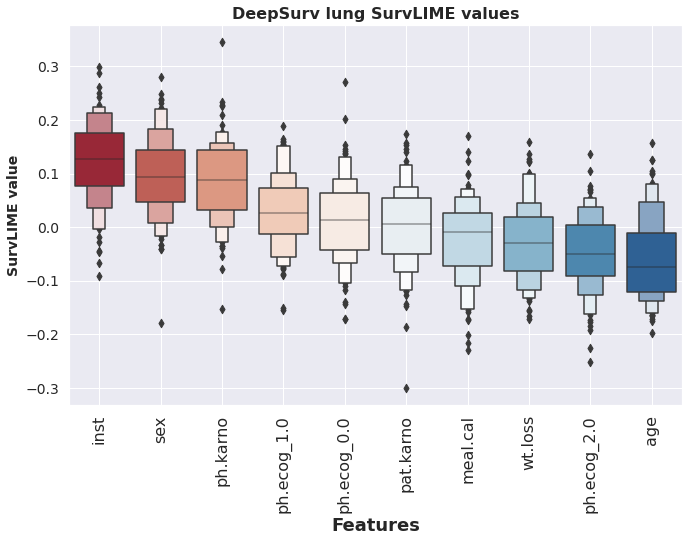

In [7]:
from tqdm import tqdm

w_path = f'/home/carlos.hernandez/PhD/survlime-paper/survLime/computed_weights_csv/exp3/'

models = ['deepsurv']#'deephit','deepsurv'] # 'xgb','rsf','cox',
datasets = ['lung']# ,'udca','lung','pbc'
length = 100

for dataset in datasets:
    for model_type in models:
        mean_dfs = []
        good_ones = []
        for i in tqdm(range(length)):
            

            compt_weights = pd.read_csv(w_path+f'{model_type}_exp_{dataset}_surv_weights_na_rand_seed_{i}.csv')
            try:
            # import ipdb;ipdb.set_trace()
                compt_weights.drop('ph.ecog_3.0', inplace=True, axis=1)
                cols= compt_weights.columns
                compt_weights = compt_weights.dropna(axis=0)
                mean_dfs.append(compt_weights.mean())
            except:
                pass
                print(i)


        pru = pd.DataFrame(data=mean_dfs, columns=cols)
        pru = pru.reindex(pru.median().sort_values(ascending=False).index, axis=1)


        fig, ax= plt.subplots(1,1, figsize=(11,7), sharey=True)
        ax.tick_params(labelrotation=90); #ax.xaxis.grid(True)
        p = sns.boxenplot(x="variable", y="value", data=pd.melt(pru), palette='RdBu',
                                            ax=ax) #'GnBu_r'
        ax.tick_params(labelrotation=90); #ax.xaxis.grid(True)
        p.set_xlabel('Features', fontsize= 18, fontweight='bold')
        p.set_ylabel('SurvLIME value', fontsize= 14, fontweight='bold')
        p.yaxis.grid(True)
        p.xaxis.grid(True)
        model_name = change_name(model_type)
        p.set_title(f'{model_name} {dataset} SurvLIME values', fontsize= 16, fontweight='bold');

        
        plt.xticks(fontsize=16, rotation=90)
        plt.yticks(fontsize=14, rotation=0)

        plt.savefig(f'figures/final_figures/{model_type}_{dataset}_inverted_colours.png',  bbox_inches='tight', dpi=200)


### This part updates the colours of the plots with the new palettes

In [ ]:
from tqdm import tqdm

w_path = f'/home/carlos.hernandez/PhD/survlime-paper/survLime/computed_weights_csv/exp3/'

models = ['rsf'] # 'lung', 'udca','lung', 'xgb'
datasets = ['pbc'] # 'lung', 'udca','lung',
length = 100

for dataset in datasets:
    for model_type in models:
        mean_dfs = []
        good_ones = []
        #import ipdb;ipdb.set_trace()

        for i in tqdm(range(length)):
            compt_weights = pd.read_csv(w_path+f'{model_type}_exp_{dataset}_surv_weights_na_rand_seed_{i}.csv')
            #if model_type=='rsf' and dataset=='pbc':
            #f        import ipdb;ipdb.set_trace()
            try:
              #  if 'ph.ecog_3.0' in compt_weights.columns:
              #      compt_weights.drop('ph.ecog_3.0', inplace=True, axis=1)
                cols= compt_weights.columns
                
                compt_weights = compt_weights.dropna(axis=0)
                import ipdb;ipdb.set_trace()
                mean_dfs.append(compt_weights.mean())
                
            except:
                import traceback
                traceback.print_exc()
                print(i)

        
        
        pru = pd.DataFrame(data=mean_dfs, columns=cols)
        pru = pru.reindex(pru.median().sort_values(ascending=False).index, axis=1)
        data = pru.copy()
        median_up = {}
        median_down = {}
        threshold = 0
        
        for (columnName, columnData) in data.items():
            median_value = np.median(columnData)
            if median_value > threshold:
                median_up[columnName] = median_value
            else:
                median_down[columnName] = median_value

        median_up = dict(
            sorted(median_up.items(), key=lambda item: item[1], reverse=True)
        )
        median_down = dict(
            sorted(median_down.items(), key=lambda item: item[1], reverse=True)
        )
        
        pal_up = sns.color_palette("Reds_r", n_colors=len(median_up))
        pal_down = sns.color_palette("Blues", n_colors=len(median_down))
        colors_up = {key: val for key, val in zip(median_up.keys(), pal_up)}
        colors_down = {key: val for key, val in zip(median_down.keys(), pal_down)}
        custom_pal = {**colors_up, **colors_down}
        data_reindex = data.reindex(columns=custom_pal.keys())
        data_melt = pd.melt(data_reindex)

        _, ax = plt.subplots(figsize=(11,7))
        ax.tick_params(labelrotation=90)
        p = sns.boxenplot(
            x="variable",
            y="value",
            data=data_melt,
            palette=custom_pal,
            ax=ax,
        )
        p.set_xlabel('Features', fontsize= 18, fontweight='bold')
        p.set_ylabel('SurvLIME value', fontsize= 14, fontweight='bold')
        p.yaxis.grid(True)
        p.xaxis.grid(True)
        model_name = change_name(model_type)
        p.set_title(f'{model_name} {dataset} SurvLIME values', fontsize= 16, fontweight='bold');

        
        plt.xticks(fontsize=16, rotation=90)
        plt.yticks(fontsize=14, rotation=0)

        plt.savefig(f'figures/final_figures/{model_type}_{dataset}_inverted_colours.png',  bbox_inches='tight', dpi=200)

  0%|                                                                                                            | 0/100 [00:00<?, ?it/s]

> /tmp/ipykernel_2018795/1438757226.py(19)<module>()
     18                     import ipdb;ipdb.set_trace()
---> 19             try:
     20                 if 'ph.ecog_3.0' in compt_weights.columns:



ipdb>  c


> /tmp/ipykernel_2018795/1438757226.py(26)<module>()
     25                 import ipdb;ipdb.set_trace()
---> 26                 mean_dfs.append(compt_weights.mean())
     27 



ipdb>  compt_weights


Empty DataFrame
Columns: [age, bili, chol, albumin, ast, ascites, copper, alk.phos, trig, platelet, protime, trt, sex, hepato, spiders, edema_1.0, edema_0.0, edema_0.5, stage_4.0, stage_3.0, stage_2.0, stage_1.0]
Index: []

[0 rows x 22 columns]


ipdb>  exit


Traceback (most recent call last):
  File "/tmp/ipykernel_2018795/1438757226.py", line 26, in <module>
    mean_dfs.append(compt_weights.mean())
  File "/tmp/ipykernel_2018795/1438757226.py", line 26, in <module>
    mean_dfs.append(compt_weights.mean())
  File "/usr/lib/python3.8/bdb.py", line 88, in trace_dispatch
    return self.dispatch_line(frame)
  File "/usr/lib/python3.8/bdb.py", line 113, in dispatch_line
    if self.quitting: raise BdbQuit
bdb.BdbQuit
  1%|▉                                                                                                 | 1/100 [00:37<1:02:03, 37.61s/it]

0
> /tmp/ipykernel_2018795/1438757226.py(18)<module>()
     17             if model_type=='rsf' and dataset=='pbc':
---> 18                     import ipdb;ipdb.set_trace()
     19             try:



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 521.62it/s]


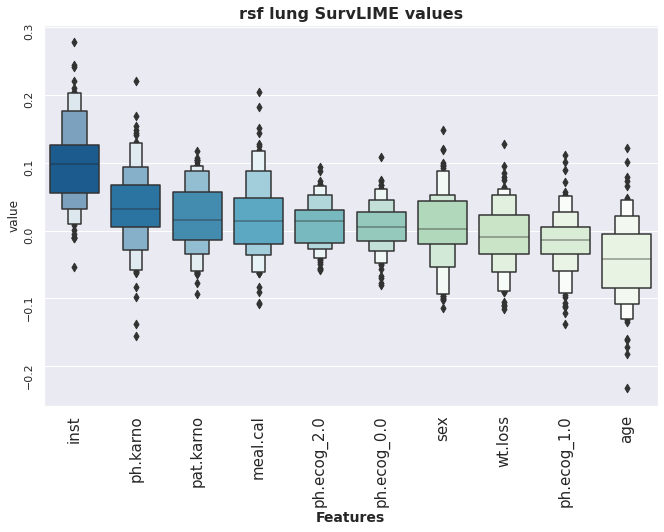

In [15]:
# fontweight='bold')
#p.set_ylim([-1, 2])# p.set_ylim([-0.01, 0.20]) OS
p.set_title(f'{model_type} {dataset} SurvLIME values', fontsize= 16, fontweight='bold');
ax.tick_params(axis='x', which='major', labelsize=15)

plt.savefig(f'figures/{model_type}_{dataset}.png',  bbox_inches='tight', dpi=200)

In [38]:
sns.set(
        style="ticks",                   # The 'ticks' style
        rc={"figure.figsize": (6, 9),      # width = 6, height = 9
            "figure.facecolor": "white",  # Figure colour
            "axes.facecolor": "turquoise"})  # Axes colour